In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log
from sklearn.preprocessing import LabelEncoder

In [2]:
train_set = pd.read_csv('../Comp/education-attainment-prediction-2025/CENSUS_ED_ATTN.csv')
test_set = pd.read_csv('../Comp/education-attainment-prediction-2025/Census_Test.csv')

A_HGA is our target variable

In [3]:
def clean_split_data(df, target, train_size=0.75, tune_size=0.15, random_state=21):
    #df = pd.get_dummies(df, columns=['PARENT', 'ERN_SRCE', 'A_MARITL', 'PEPAR1TYP', 'PEHSPNON', 'PRCITSHP'], drop_first=True)
    #for col in ['A_SEX', 'PENATVTY', 'PEFNTVTY']:
        #df[col] = LabelEncoder().fit_transform(df[col])
 
    X = df.drop(columns=['A_HGA', 'PEAFEVER']) 
    X[['PENATVTY', 'PEFNTVTY', 'PRDTRACE']] = X[['PENATVTY', 'PEFNTVTY', 'PRDTRACE']].astype('category')
    
    y = df[target].astype('category')

    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

# Use the function to split the movie data
X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(train_set, 'A_HGA')

In [4]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)

In [5]:
scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro']
#only go to 5, because everything after is diminishing returns
param={"max_depth" : [1,2,3,4,5,6,7,8,9,10],
           }

In [6]:
#cl= DecisionTreeClassifier(random_state=1000, class_weight='balanced')
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1000, n_jobs=-1, class_weight='balanced')
search = GridSearchCV(clf, param, scoring=scoring, n_jobs=1, cv=kf, refit='balanced_accuracy', return_train_score=True)

In [7]:
model = search.fit(X_train, y_train)

In [8]:
best= model.best_estimator_
print(best)

plt.figure(figsize=(20,10))
plot_tree(best, feature_names=X_train.columns, class_names=[str(label) for label in y_train.unique()], filled=True, rounded=True)
plt.show()

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=1000)


InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=1000) instead.

<Figure size 2000x1000 with 0 Axes>

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      1  0.248918  0.179928  0.179928  0.075200    0.006713  0.005353   
1      2  0.252127  0.195300  0.195300  0.093335    0.002972  0.007345   
2      3  0.272096  0.217797  0.217797  0.125219    0.003822  0.007376   
3      4  0.295948  0.225080  0.225080  0.143443    0.004663  0.006961   
4      5  0.310205  0.229438  0.229438  0.152611    0.005571  0.007450   
5      6  0.310344  0.233334  0.233334  0.156244    0.005384  0.007044   
6      7  0.317598  0.235305  0.235305  0.159803    0.004587  0.007218   
7      8  0.321091  0.237933  0.237933  0.161717    0.003554  0.006593   
8      9  0.327370  0.239158  0.239158  0.164510    0.004179  0.008388   
9     10  0.330892  0.240833  0.240833  0.167432    0.004494  0.007723   

   bal_accSD      f1SD  
0   0.005353  0.005264  
1   0.007345  0.003909  
2   0.007376  0.003608  
3   0.006961  0.004000  
4   0.007450  0.003597  
5   0.007044  0.003005  
6   0.0072

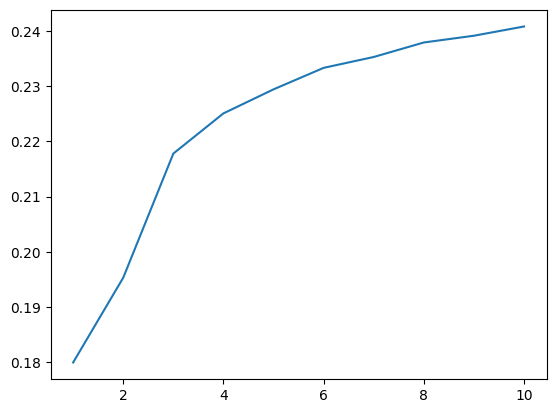

In [9]:
np.random.seed(1)
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model)
plt.plot(final_model['depth'], final_model['bal_acc'], label='Accuracy')

           importance
WSAL_VAL     0.180390
PARENT       0.175829
PENATVTY     0.108801
PEINUSYR     0.094908
PEFNTVTY     0.093101
PEPAR1TYP    0.077567
A_MARITL     0.065710
ERN_SRCE     0.058630
PRCITSHP     0.048853
PRDTRACE     0.037830
PEHSPNON     0.029293
A_SEX        0.023496
ANN_VAL      0.005591


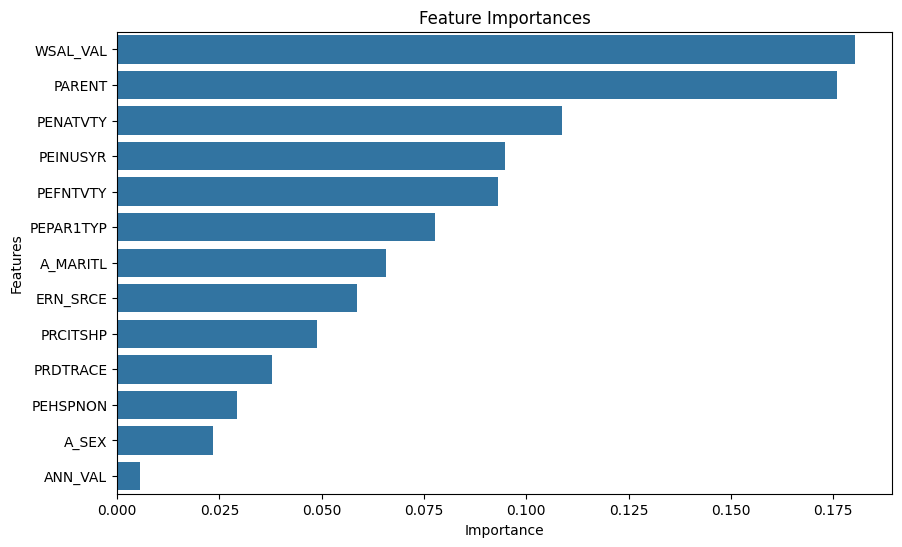

In [10]:
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [11]:
tune_predictions = pd.DataFrame(model.predict(X_tune), columns=['Predicted_Label']) 

percentages = tune_predictions['Predicted_Label'].value_counts(normalize=True) * 100

# Convert to a table format
table = percentages.reset_index()
table.columns = ['Label', 'Percentage']

# Print the table
print("Percentage of Each Predicted Label:")
print(table)

Percentage of Each Predicted Label:
    Label  Percentage
0       0   24.042179
1      39   12.917399
2      42   12.601054
3      41    9.507909
4      44    6.608084
5      33    5.342707
6      46    5.166960
7      37    4.323374
8      45    3.901582
9      40    3.602812
10     31    3.145870
11     38    2.741652
12     32    2.442882
13     43    2.214411
14     36    1.001757
15     34    0.263620
16     35    0.175747


In [12]:
from sklearn.metrics import precision_score, classification_report

# Predict on test set using best estimator
y_pred = search.best_estimator_.predict(X_test)

# Macro precision
macro_prec = precision_score(y_test, y_pred, average='macro')
print(f"Macro Precision on Test Set: {macro_prec:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Macro Precision on Test Set: 0.1959

Classification Report:
              precision    recall  f1-score   support

           0     0.8551    0.9955    0.9200      6684
          31     0.0189    0.2466    0.0351        73
          32     0.0737    0.4241    0.1256       158
          33     0.0857    0.4783    0.1453       299
          34     0.0769    0.0072    0.0132       555
          35     0.1566    0.0187    0.0334       695
          36     0.3701    0.1197    0.1809       785
          37     0.1452    0.2011    0.1686       890
          38     0.0333    0.0687    0.0448       451
          39     0.3879    0.2233    0.2834      7067
          40     0.2594    0.0798    0.1221      3958
          41     0.0628    0.1884    0.0942      1035
          42     0.0846    0.2544    0.1270      1372
          43     0.3308    0.0514    0.0890      5155
          44     0.2417    0.2254    0.2332      2254
          45     0.0767    0.2985    0.1220       335
          46     0.07

In [13]:
# Predict the target variable for the test set
test_set = test_set.drop(columns=['PEAFEVER'])
test_predictions = model.best_estimator_.predict(test_set)

# Add predictions to the test set
test_set.index = test_set.index + 1
test_set.index.name = 'ID'
test_set['A_HGA'] = test_predictions


# Keep only the Predicted_Score and index
test_set = test_set[['A_HGA']]
print(test_set)
# Save the predictions to a CSV file
test_set.to_csv('predictions.csv', index=True, header=True)

     A_HGA
ID        
1        0
2       46
3       43
4       37
5        0
..     ...
981     41
982     37
983      0
984      0
985      0

[985 rows x 1 columns]
